In [18]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

# Code References
#https://www.kaggle.com/code/hamzamanssor/surface-crack-detection-using-dl-models/notebook#Functions

In [19]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

training_dir = '/content/Data/training'
evaluate_dir = '/content/Data/evaluate'

# METU
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/data.zip', 'r')
zip_ref.extractall(evaluate_dir)
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/Utah_dup.zip', 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
path = '/content/Data/training/Utah/'
path_all = list(glob.glob(path+'**/*png'))
path_Negative = path + 'U/*.png'
path_Positive = path + 'C/*.png'

In [22]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,/content/Data/training/Utah/U/7077-86.png,U
1,/content/Data/training/Utah/U/078-189.png,U
2,/content/Data/training/Utah/U/026-90.png,U
3,/content/Data/training/Utah/U/095-176.png,U
4,/content/Data/training/Utah/U/7006-180.png,U


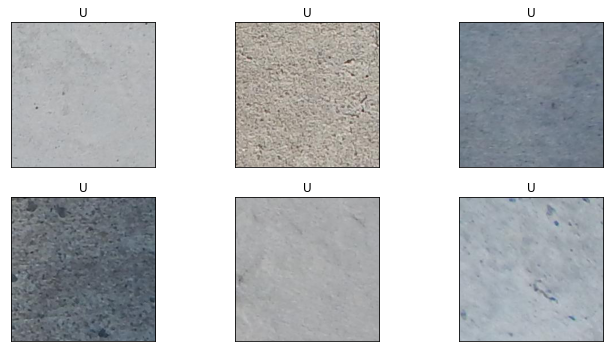

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i],0))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [24]:
# Train and test split
train_df, test_df = train_test_split(data, test_size=0.2, stratify = data["Label"])

In [25]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [26]:
def func(name_model):
    pre_model = name_model(input_shape=(224,224, 3),
                   include_top=True,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [27]:
def plot(history,df_test,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["Positive", "Negative"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1],0))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [28]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

#VGG16

In [50]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)

Found 51660 validated image filenames belonging to 2 classes.
Found 51660 validated image filenames belonging to 2 classes.
Found 12916 validated image filenames belonging to 2 classes.


In [51]:
VGG_16_model, callback=func(VGG16)

553476096/553467096 [==============================] - 3s 0us/step


In [52]:
history = VGG_16_model.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
808/808 [==============================] - 307s 378ms/step - loss: 0.4551 - accuracy: 0.8030 - val_loss: 0.4056 - val_accuracy: 0.8282
Epoch 2/100
808/808 [==============================] - 302s 374ms/step - loss: 0.3995 - accuracy: 0.8317 - val_loss: 0.3830 - val_accuracy: 0.8400
Epoch 3/100
808/808 [==============================] - 301s 372ms/step - loss: 0.3825 - accuracy: 0.8412 - val_loss: 0.3778 - val_accuracy: 0.8435
Epoch 4/100
808/808 [==============================] - 303s 375ms/step - loss: 0.3734 - accuracy: 0.8460 - val_loss: 0.3613 - val_accuracy: 0.8517
Epoch 5/100
808/808 [==============================] - 305s 378ms/step - loss: 0.3662 - accuracy: 0.8492 - val_loss: 0.3561 - val_accuracy: 0.8561
Epoch 6/100
808/808 [==============================] - 304s 376ms/step - loss: 0.3599 - accuracy: 0.8528 - val_loss: 0.3522 - val_accuracy: 0.8558
Epoch 7/100
808/808 [==============================] - 304s 376ms/step - loss: 0.3537 - accuracy: 0.8555 - val_loss: 0

              precision    recall  f1-score   support

    Positive       0.75      0.64      0.69      3394
    Negative       0.88      0.92      0.90      9522

    accuracy                           0.85     12916
   macro avg       0.81      0.78      0.80     12916
weighted avg       0.84      0.85      0.85     12916



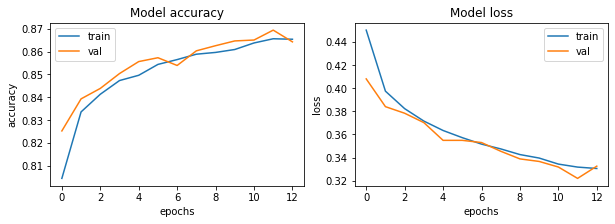

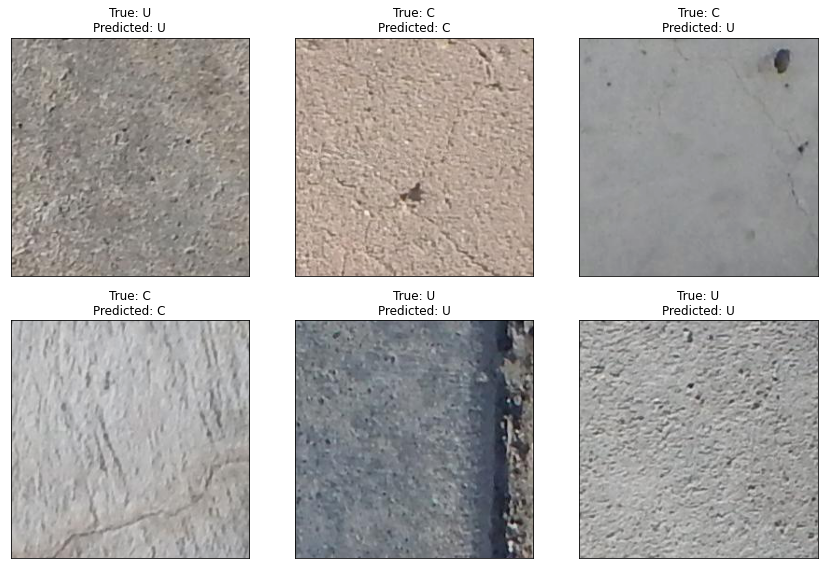

In [ ]:
history=plot(history,test_df,test_gen_VGG,train_gen_VGG,VGG_16_model)

In [ ]:
result = result_test(test_gen_VGG,VGG_16_model)

    Test Loss: 0.36656
Test Accuracy: 84.96%


In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name = 'Label', index = filepaths.index)
    df = pd.concat([filepaths, labels], axis = 1)
    return df

from pathlib import Path

# Set to the respective directory category of unseen data
positive_Decks_dir = Path("../input/structural-defects-network-concrete-crack-images/Decks/Cracked")
negative_Decks_dir = Path("../input/structural-defects-network-concrete-crack-images/Decks/Non-cracked")

positive_Pavements_dir = Path("../input/structural-defects-network-concrete-crack-images/Pavements/Cracked")
negative_Pavements_dir = Path("../input/structural-defects-network-concrete-crack-images/Pavements/Non-cracked")

positive_Walls_dir = Path("../input/structural-defects-network-concrete-crack-images/Walls/Cracked")
negative_Walls_dir = Path("../input/structural-defects-network-concrete-crack-images/Walls/Non-cracked")


# create positive and negative df
positive_Decks_df = generate_df(positive_Decks_dir, label = "POSITIVE")
negative_Decks_df = generate_df(negative_Decks_dir, label = "NEGATIVE")

positive_Pavements_df = generate_df(positive_Pavements_dir, label = "POSITIVE")
negative_Pavements_df = generate_df(negative_Pavements_dir, label = "NEGATIVE")

positive_Walls_df = generate_df(positive_Walls_dir, label = "POSITIVE")
negative_Walls_df = generate_df(negative_Walls_dir, label = "NEGATIVE")

In [ ]:
positive_Decks_df["Filepath"][0]

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
import numpy as np

# Create boolean function
def label_generator(index):
    if index == 1:
        return 1
    else:
        return 0

# Create getter function 
# Inputs are your image directories and the CNN model
def single_prediction_generator(image_dir,model):
    img_path = image_dir
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    # Return the confidence interval for image
    prediction = model.predict(img_preprocessed)
    index = np.argmax(prediction[0])
    label = label_generator(index)
    
    # Return index
    return label

# return an array of the predicted labels
def prediction_array_generator(category_df,model):
    predicted_label = []
    
    # Iterate through the dataframe
    for image_dir in category_df['Filepath']:
        temp = single_prediction_generator(image_dir,model)
        predicted_label.append(temp)        
    
    # Return the list of the prediction label
    return predicted_label


# Resnet 50

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 51660 validated image filenames belonging to 2 classes.
Found 51660 validated image filenames belonging to 2 classes.
Found 12916 validated image filenames belonging to 2 classes.


In [30]:
ResNet50_model, callback=func(ResNet50)

In [ ]:
ResNet50_model.summary()

In [31]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
808/808 [==============================] - 295s 361ms/step - loss: 0.4257 - accuracy: 0.8178 - val_loss: 0.3730 - val_accuracy: 0.8480
Epoch 2/100
808/808 [==============================] - 288s 356ms/step - loss: 0.3670 - accuracy: 0.8510 - val_loss: 0.3507 - val_accuracy: 0.8592
Epoch 3/100
808/808 [==============================] - 289s 357ms/step - loss: 0.3466 - accuracy: 0.8595 - val_loss: 0.3295 - val_accuracy: 0.8686
Epoch 4/100
808/808 [==============================] - 290s 359ms/step - loss: 0.3326 - accuracy: 0.8667 - val_loss: 0.3225 - val_accuracy: 0.8703
Epoch 5/100
808/808 [==============================] - 288s 356ms/step - loss: 0.3213 - accuracy: 0.8717 - val_loss: 0.3092 - val_accuracy: 0.8772
Epoch 6/100
808/808 [==============================] - 288s 356ms/step - loss: 0.3130 - accuracy: 0.8756 - val_loss: 0.3012 - val_accuracy: 0.8792
Epoch 7/100
808/808 [==============================] - 290s 358ms/step - loss: 0.3063 - accuracy: 0.8781 - val_loss: 0

              precision    recall  f1-score   support

    Positive       0.80      0.73      0.76      3394
    Negative       0.91      0.93      0.92      9522

    accuracy                           0.88     12916
   macro avg       0.85      0.83      0.84     12916
weighted avg       0.88      0.88      0.88     12916



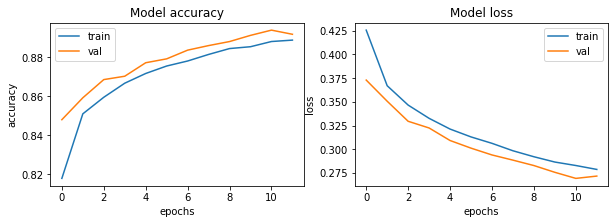

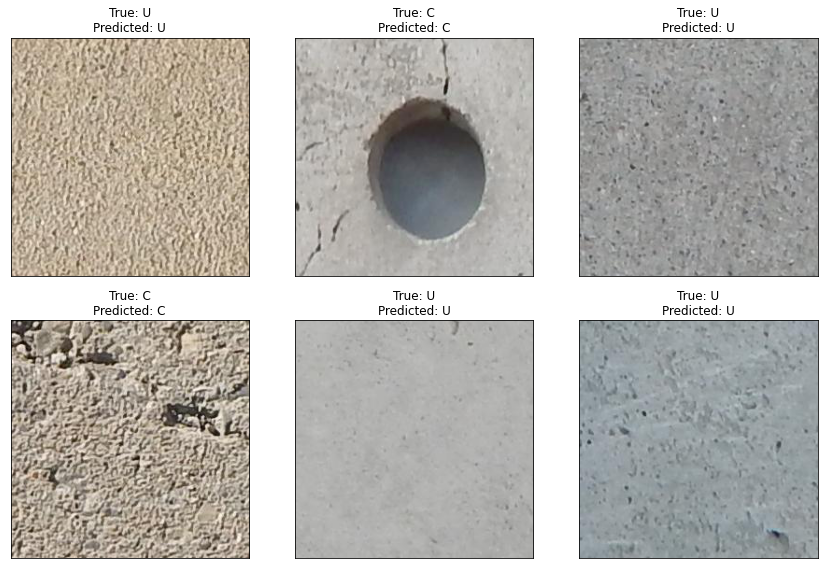

In [32]:
history_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet,ResNet50_model)

In [33]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

    Test Loss: 0.29757
Test Accuracy: 88.07%


In [34]:
result_ResNet

[0.2975715696811676, 0.8806906342506409]

# Resnet 50 Prediction

In [37]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name = 'Label', index = filepaths.index)
    df = pd.concat([filepaths, labels], axis = 1)
    return df

from pathlib import Path

# Set to the respective directory category of unseen data
positive_Images_dir = Path("/content/Data/evaluate/images/Positive")
negative_Images_dir = Path("/content/Data/evaluate/images/Negative")

# create positive and negative df
positive_Images_df = generate_df(positive_Images_dir, label = "POSITIVE")
negative_Images_df = generate_df(negative_Images_dir, label = "NEGATIVE")


In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
import numpy as np

# Create boolean function
def label_generator(index):
    if index == 0:
        return "POSITIVE"
    else:
        return "NEGATIVE"

# Create getter function 
# Inputs are your image directories and the CNN model
def single_prediction_generator(image_dir,model):
    img_path = image_dir
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    # Return the confidence interval for image
    prediction = model.predict(img_preprocessed)
    index = np.argmax(prediction[0])
    label = label_generator(index)
    
    # Return index
    return label

# return an array of the predicted labels
def prediction_array_generator(category_df,model):
    predicted_label = []
    
    # Iterate through the dataframe
    for image_dir in category_df['Filepath']:
        temp = single_prediction_generator(image_dir,model)
        predicted_label.append(temp)        
    
    # Return the list of the prediction label
    return predicted_label


In [ ]:
positive_pred_label = prediction_array_generator(positive_Images_df,ResNet50_model)
negative_pred_label = prediction_array_generator(negative_Images_df,ResNet50_model)


In [ ]:
positive_pred_label

In [ ]:
negative_pred_label

In [ ]:
img_path = "/content/Data/evaluate/images/Negative/01693.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = ResNet50_model.predict(img_preprocessed)
prediction

array([[0.01249867, 0.9875014 ]], dtype=float32)

In [ ]:
print(metrics.confusion_matrix(y_act, y_pred, labels=["a", "b", "c"]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=["a", 
"b","c"]))

In [ ]:
# Insert the prediction columns into the dataframe

positive_Images_df.insert(2,"Resnet-50",positive_pred_label)
negative_Images_df.insert(2,"Resnet-50",negative_pred_label)

In [ ]:
negative_Images_df

,Filepath,Label,Resnet-50
0,/content/Data/evaluate/images/Negative/02805.jpg,NEGATIVE,NEGATIVE
1,/content/Data/evaluate/images/Negative/07542.jpg,NEGATIVE,POSITIVE
2,/content/Data/evaluate/images/Negative/00171.jpg,NEGATIVE,NEGATIVE
3,/content/Data/evaluate/images/Negative/15172.jpg,NEGATIVE,NEGATIVE
4,/content/Data/evaluate/images/Negative/01229.jpg,NEGATIVE,NEGATIVE
...,...,...,...
19995,/content/Data/evaluate/images/Negative/13101.jpg,NEGATIVE,NEGATIVE
19996,/content/Data/evaluate/images/Negative/12264.jpg,NEGATIVE,NEGATIVE
19997,/content/Data/evaluate/images/Negative/19486.jpg,NEGATIVE,NEGATIVE
19998,/content/Data/evaluate/images/Negative/11991.jpg,NEGATIVE,NEGATIVE


In [ ]:
positive_Images_df

,Filepath,Label,Resnet-50
0,/content/Data/evaluate/images/Positive/18640_1...,POSITIVE,POSITIVE
1,/content/Data/evaluate/images/Positive/02805.jpg,POSITIVE,POSITIVE
2,/content/Data/evaluate/images/Positive/17386_1...,POSITIVE,POSITIVE
3,/content/Data/evaluate/images/Positive/07542.jpg,POSITIVE,POSITIVE
4,/content/Data/evaluate/images/Positive/00171.jpg,POSITIVE,NEGATIVE
...,...,...,...
19995,/content/Data/evaluate/images/Positive/14443_1...,POSITIVE,POSITIVE
19996,/content/Data/evaluate/images/Positive/19486.jpg,POSITIVE,POSITIVE
19997,/content/Data/evaluate/images/Positive/17104_1...,POSITIVE,NEGATIVE
19998,/content/Data/evaluate/images/Positive/16407_1...,POSITIVE,POSITIVE


# VGG-16 Prediction

In [ ]:
positive_pred_label2 = prediction_array_generator(positive_Images_df,VGG_16_model)
negative_pred_label2 = prediction_array_generator(negative_Images_df,VGG_16_model)

In [ ]:
positive_Images_df.insert(3,"VGG-16",positive_pred_label2)
negative_Images_df.insert(3,"VGG-16",negative_pred_label2)

# Computation of the results

In [ ]:
# Define true_positive
# return a list
# must positive quanity to be taken in
def true_positive(category_df):
    tp_models = []
    count_VGG16 = 0
    count_Resnet50 = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["Resnet-50"][i]:
          count_Resnet50 += 1
        if category_df["Label"][i] == category_df["VGG-16"][i]:
          count_VGG16 += 1
    tp_VGG = count_VGG16 
    tp_Resnet = count_Resnet50
    tp_models.append(tp_VGG)
    tp_models.append(tp_Resnet)
    return tp_models

# Define false negative
def false_negative(tp_models,category_df):
    fn_models = []
    fn_vgg = len(category_df) - tp_models[0]
    fn_resnet50 = len(category_df) - tp_models[1]
    fn_models.append(fn_vgg)
    fn_models.append(resnet50)
    return fp_models

    

In [ ]:
def true_negative(category_df):
    tn_models = []
    count_VGG16 = 0
    count_Resnet50 = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["Resnet-50"][i]:
          count_Resnet50 += 1
        if category_df["Label"][i] == category_df["VGG-16"][i]:
          count_VGG16 += 1
    tn_VGG = count_VGG16
    tn_Resnet50 = count_Resnet50
    tn_models.append(tn_VGG)
    tn_models.append(tn_Resnet50)
    return tn_models
def false_positive(tn_models,category_df):
    fp_models = []
    fp_vgg = 1 - tn_models[0]
    fp_resnet = 1 - tn_models[1]
    fp_models.append(fp_vgg)
    fp_models.append(fp_resnet)
    return fp_models


In [ ]:
yes = true_positive(positive_Images_df)
yes

In [ ]:
no = true_negative(negative_Images_df)

NameError: ignored

# Resnet 50 prediction blur

In [38]:
positive_Images_dir2 = Path("/content/Data/evaluate/data/blur/Positive")
negative_Images_dir2 = Path("/content/Data/evaluate/data/blur/Negative")

In [39]:
# create positive and negative df
positive_Images_df2 = generate_df(positive_Images_dir2, label = "POSITIVE")
negative_Images_df2 = generate_df(negative_Images_dir2, label = "NEGATIVE")

In [40]:
positive_Images_df2

,Filepath,Label
0,/content/Data/evaluate/data/blur/Positive/1864...,POSITIVE
1,/content/Data/evaluate/data/blur/Positive/0280...,POSITIVE
2,/content/Data/evaluate/data/blur/Positive/1738...,POSITIVE
3,/content/Data/evaluate/data/blur/Positive/0754...,POSITIVE
4,/content/Data/evaluate/data/blur/Positive/0017...,POSITIVE
...,...,...
19995,/content/Data/evaluate/data/blur/Positive/1444...,POSITIVE
19996,/content/Data/evaluate/data/blur/Positive/1948...,POSITIVE
19997,/content/Data/evaluate/data/blur/Positive/1710...,POSITIVE
19998,/content/Data/evaluate/data/blur/Positive/1640...,POSITIVE


In [41]:
positive_pred_label3 = prediction_array_generator(positive_Images_df2,ResNet50_model)
negative_pred_label3 = prediction_array_generator(negative_Images_df2,ResNet50_model)

In [43]:
positive_pred_label3.count("POSITIVE")

10368

In [44]:
negative_pred_label3.count("NEGATIVE")

17092

In [ ]:
positive_Images_df2.insert(2,"Resnet-50",positive_pred_label3)
negative_Images_df2.insert(2,"Resnet-50",negative_pred_label3)

In [ ]:
positive_Images_df2

In [ ]:
negative_Images_df2

# VGG-16 prediction blur





In [58]:
positive_pred_label4 = prediction_array_generator(positive_Images_df2,VGG_16_model)
negative_pred_label4 = prediction_array_generator(negative_Images_df2,VGG_16_model)

In [59]:
positive_pred_label4.count("POSITIVE")

7553

In [60]:
negative_pred_label4.count("NEGATIVE")

19775

In [ ]:
positive_Images_df2.insert(3,"VGG-16",positive_pred_label4)
negative_Images_df2.insert(3,"VGG-16",negative_pred_label4)

In [ ]:
positive_Images_df2

In [ ]:
negative_Images_df2

# Computation of results blur

In [ ]:
stat3 = true_positive(positive_Images_df2)
stat3

In [ ]:
stat4 = true_negative(negative_Images_df2)
stat4

# Resnet 50 prediction bright

In [45]:
positive_Images_dir3 = Path("/content/Data/evaluate/data/bright/Positive")
negative_Images_dir3 = Path("/content/Data/evaluate/data/bright/Negative")

In [46]:
# create positive and negative df
positive_Images_df3 = generate_df(positive_Images_dir3, label = "POSITIVE")
negative_Images_df3 = generate_df(negative_Images_dir3, label = "NEGATIVE")

In [47]:
positive_pred_label5 = prediction_array_generator(positive_Images_df3,ResNet50_model)
negative_pred_label5 = prediction_array_generator(negative_Images_df3,ResNet50_model)

In [48]:
positive_pred_label5.count("POSITIVE")

15103

In [49]:
negative_pred_label5.count("NEGATIVE")

15530

In [ ]:
positive_Images_df3.insert(2,"Resnet-50",positive_pred_label5)
negative_Images_df3.insert(2,"Resnet-50",negative_pred_label5)

In [ ]:
positive_Images_df3

In [ ]:
negative_Images_df3

# VGG-16 prediction bright

In [53]:
positive_pred_label6 = prediction_array_generator(positive_Images_df3,VGG_16_model)
negative_pred_label6 = prediction_array_generator(negative_Images_df3,VGG_16_model)

In [56]:
positive_pred_label6.count("POSITIVE")

15128

In [57]:
negative_pred_label6.count("NEGATIVE")

18430

In [ ]:
positive_Images_df3.insert(3,"VGG-16",positive_pred_label6)
negative_Images_df3.insert(3,"VGG-16",negative_pred_label6)

In [ ]:
positive_Images_df3

In [ ]:
negative_Images_df3

# Computation of bright results

In [ ]:
stat5 = true_positive(positive_Images_df3)
stat5

In [ ]:
stat6 = true_negative(negative_Images_df3)
stat6